In [17]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 preprocessing

In [5]:
# path to files
mci_path = '/content/drive/MyDrive/academic/data/NNDL/HW2/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI'
ad_path = '/content/drive/MyDrive/academic/data/NNDL/HW2/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD'

In [6]:
MCI_images = []
mci_files = [f for f in os.listdir(mci_path)]

for file_name in mci_files:
    image = cv2.imread(os.path.join(mci_path, file_name), cv2.IMREAD_GRAYSCALE) # reading image in grayscale

    image = cv2.resize(image, (64, 64)) # resizing to (64, 64)

    image = image/255.0 # normalization

    MCI_images.append(image)

In [7]:
AD_images = []
ad_files = [f for f in os.listdir(ad_path)]

for file_name in ad_files:
    image = cv2.imread(os.path.join(ad_path, file_name), cv2.IMREAD_GRAYSCALE) # reading image in grayscale

    image = cv2.resize(image, (64, 64)) # resizing to (64, 64)

    image = image/255.0 # normalization

    AD_images.append(image)

In [8]:
print('length of MCI_images (number of MCI images):', len(MCI_images))
print('length of AD_images (number of AD images):', len(AD_images))
print('total number of images:', len(AD_images)+len(MCI_images))

length of MCI_images (number of MCI images): 689
length of AD_images (number of AD images): 965
total number of images: 1654


In [9]:
X = np.concatenate((MCI_images, AD_images))
y = np.concatenate((np.zeros(len(MCI_images)), np.ones(len(AD_images)))) # labeling MCI: 0 and AD: 1

## 1.3 : data augmentation

#### before augmentation

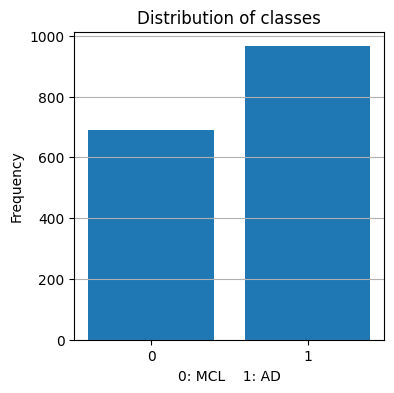

In [10]:
plt.figure(figsize=(4, 4))
plt.hist(y, bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.8)
plt.xlabel('0: MCL    1: AD')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.xticks([0, 1])
plt.grid(axis='y')
plt.show()

#### augmentation

In [11]:
datagenerator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

In [12]:
aug_X = X
aug_y = y

aug_X = np.expand_dims(aug_X, axis=-1)  # Add channel dimension for grayscale image

augmented_data = datagenerator.flow(aug_X, aug_y, batch_size=len(aug_X), shuffle=False)

for _ in range(4):
    augmented_images, augmented_labels = augmented_data.next()
    aug_X = np.concatenate((aug_X, augmented_images))
    aug_y = np.concatenate((aug_y, augmented_labels))

print('total number of images after the augmentation: ', len(aug_X))


total number of images after the augmentation:  8270


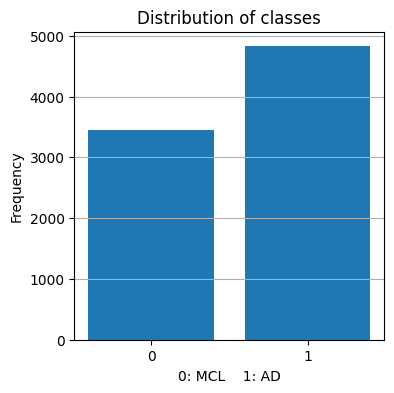

In [13]:
plt.figure(figsize=(4, 4))
plt.hist(aug_y, bins=[-0.5, 0.5, 1.5], align='mid', rwidth=0.8)
plt.xlabel('0: MCL    1: AD')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.xticks([0, 1])
plt.grid(axis='y')
plt.show()

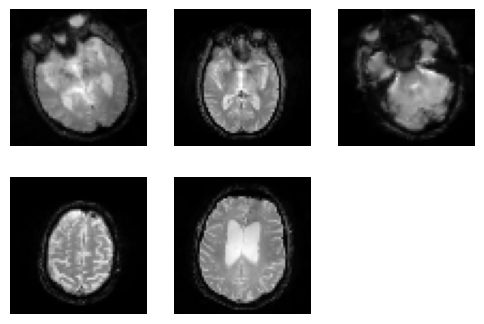

In [14]:
plt.figure(figsize=(6, 4))
for i in range(5):
    random_index = np.random.randint(0, len(aug_X))
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(aug_X[random_index], cmap='gray')

plt.show()


#### spliting data into train and test

In [93]:
X_train, X_test, y_train, y_test = train_test_split(aug_X, aug_y, test_size=0.05, stratify=aug_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [94]:
# making labels on-hot
num_classes = 2
y_train = tf.one_hot(y_train, depth=num_classes)
y_val = tf.one_hot(y_val, depth=num_classes)
y_test = tf.one_hot(y_test, depth=num_classes)

## 1.4 Model implementation

#### Initializing

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

In [96]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [97]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [98]:
def dice_coefficient(y_true, y_pred):

    intersection = np.logical_and(y_true, y_pred).sum()

    dice = 2. * intersection / (y_true.sum() + y_pred.sum())
    return dice

#### Proposed Model

In [99]:
proposed_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(64, activation='relu'),

    Dense(2, activation='softmax')
])


proposed_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

proposed_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_63 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                               

#### Testing Model 1

In [100]:
test_model_1 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(2, activation='softmax')
])

test_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_1.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 8192)              0         
                                                                 
 dense_64 (Dense)            (None, 128)             

#### Testing Model 2

In [101]:
test_model_2 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

test_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_2.summary()


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_67 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_25 (Flatten)        (None, 32768)             0         
                                                                 
 dense_66 (Dense)            (None, 128)               4194432   
                                                                 
 dense_67 (Dense)            (None, 64)                8256      
                                                     

## 1.5 : Results

In [102]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


    ax1.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')


    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper left')


    plt.tight_layout()
    plt.show()

In [103]:
def dice_coefficient(y_true, y_pred):

    intersection = np.logical_and(y_true, y_pred).sum()

    dice = 2. * intersection / (y_true.sum() + y_pred.sum())
    return dice


def print_results(model, X_test, y_test):

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_test, axis=1)

    print("classification report:")
    print(classification_report(y_true, y_pred))
    print("confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    # DCS Metric
    print('dcs measure:', dice_coefficient(y_true, y_pred))

    # ROC - AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate AUC (Area Under the Curve)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC:", auc)

    # Create ROC plot
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [104]:
def evaluate_models(proposed_model, test_model_1, test_model_2, X_train, y_train, X_val, y_val, X_test, y_test, epochs=20):
    print("PROPOSED MODEL:")
    proposed_model_history = proposed_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    print_results(proposed_model, X_test, y_test)
    plot_history(proposed_model_history)

    print('\n\n\n')
    print("TESTING MODEL 1:")
    test_model_1_history = test_model_1.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    print_results(test_model_1, X_test, y_test)
    plot_history(test_model_1_history)

    print('\n\n\n')
    print("TESTING MODEL 2:")
    test_model_2_history = test_model_2.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))
    print_results(test_model_2, X_test, y_test)
    plot_history(test_model_2_history)


PROPOSED MODEL:
Epoch 1/20
221/221 [==============================] - 5s 11ms/step - loss: 0.6261 - accuracy: 0.6382 - val_loss: 0.6054 - val_accuracy: 0.6438
Epoch 2/20
221/221 [==============================] - 3s 12ms/step - loss: 0.5863 - accuracy: 0.6897 - val_loss: 0.5701 - val_accuracy: 0.7074
Epoch 3/20
221/221 [==============================] - 3s 13ms/step - loss: 0.5543 - accuracy: 0.7205 - val_loss: 0.5478 - val_accuracy: 0.7226
Epoch 4/20
221/221 [==============================] - 4s 19ms/step - loss: 0.5141 - accuracy: 0.7504 - val_loss: 0.5107 - val_accuracy: 0.7455
Epoch 5/20
221/221 [==============================] - 3s 15ms/step - loss: 0.4678 - accuracy: 0.7750 - val_loss: 0.4697 - val_accuracy: 0.7812
Epoch 6/20
221/221 [==============================] - 3s 12ms/step - loss: 0.4126 - accuracy: 0.8079 - val_loss: 0.4804 - val_accuracy: 0.7837
Epoch 7/20
221/221 [==============================] - 3s 12ms/step - loss: 0.3620 - accuracy: 0.8308 - val_loss: 0.4805 - val_

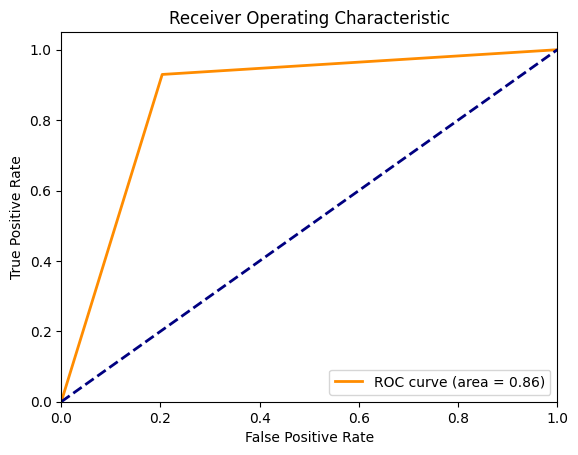

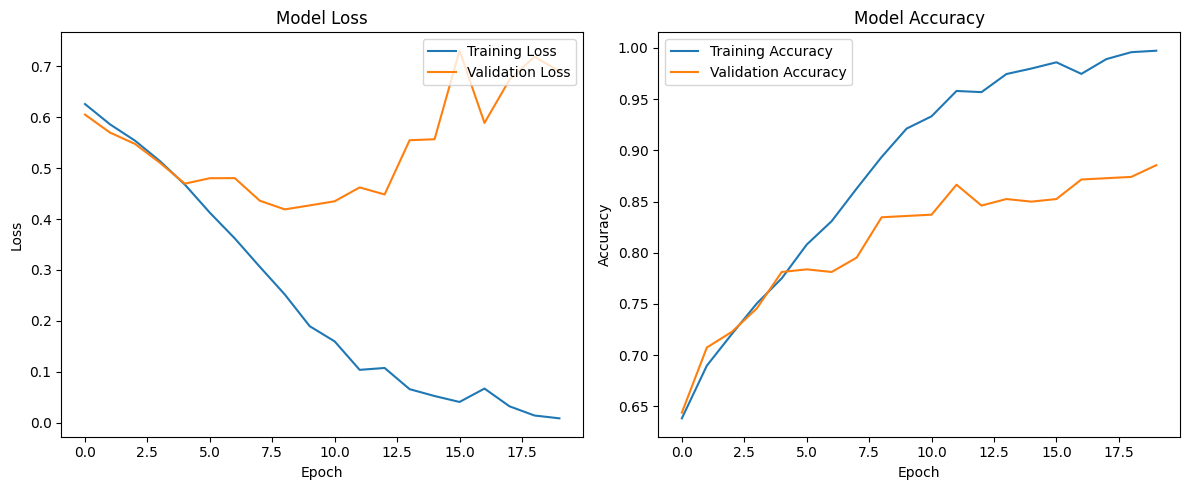





TESTING MODEL 1:
Epoch 1/20
221/221 [==============================] - 3s 8ms/step - loss: 0.6134 - accuracy: 0.6501 - val_loss: 0.5957 - val_accuracy: 0.6616
Epoch 2/20
221/221 [==============================] - 1s 7ms/step - loss: 0.5615 - accuracy: 0.7092 - val_loss: 0.5779 - val_accuracy: 0.6743
Epoch 3/20
221/221 [==============================] - 1s 5ms/step - loss: 0.5269 - accuracy: 0.7382 - val_loss: 0.5382 - val_accuracy: 0.7265
Epoch 4/20
221/221 [==============================] - 1s 5ms/step - loss: 0.4871 - accuracy: 0.7652 - val_loss: 0.5017 - val_accuracy: 0.7774
Epoch 5/20
221/221 [==============================] - 1s 6ms/step - loss: 0.4479 - accuracy: 0.7873 - val_loss: 0.4799 - val_accuracy: 0.7824
Epoch 6/20
221/221 [==============================] - 1s 5ms/step - loss: 0.4063 - accuracy: 0.8136 - val_loss: 0.4593 - val_accuracy: 0.7837
Epoch 7/20
221/221 [==============================] - 1s 5ms/step - loss: 0.3672 - accuracy: 0.8331 - val_loss: 0.4724 - val_ac

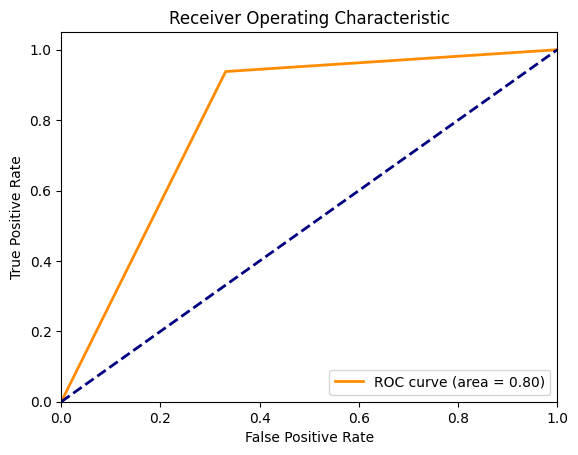

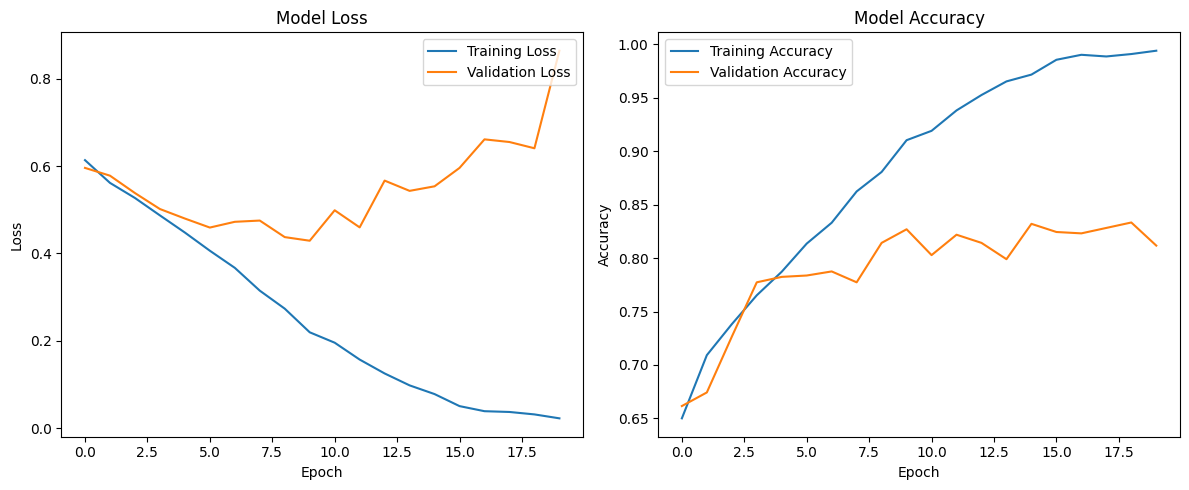





TESTING MODEL 2:
Epoch 1/20
221/221 [==============================] - 7s 16ms/step - loss: 0.6256 - accuracy: 0.6424 - val_loss: 0.5871 - val_accuracy: 0.6921
Epoch 2/20
221/221 [==============================] - 6s 25ms/step - loss: 0.5577 - accuracy: 0.7106 - val_loss: 0.5599 - val_accuracy: 0.7048
Epoch 3/20
221/221 [==============================] - 3s 13ms/step - loss: 0.5127 - accuracy: 0.7465 - val_loss: 0.5715 - val_accuracy: 0.6896
Epoch 4/20
221/221 [==============================] - 3s 13ms/step - loss: 0.4401 - accuracy: 0.7938 - val_loss: 0.5462 - val_accuracy: 0.7265
Epoch 5/20
221/221 [==============================] - 2s 8ms/step - loss: 0.3714 - accuracy: 0.8362 - val_loss: 0.5730 - val_accuracy: 0.7112
Epoch 6/20
221/221 [==============================] - 2s 8ms/step - loss: 0.2746 - accuracy: 0.8779 - val_loss: 0.6327 - val_accuracy: 0.7519
Epoch 7/20
221/221 [==============================] - 2s 9ms/step - loss: 0.1955 - accuracy: 0.9177 - val_loss: 0.7174 - va

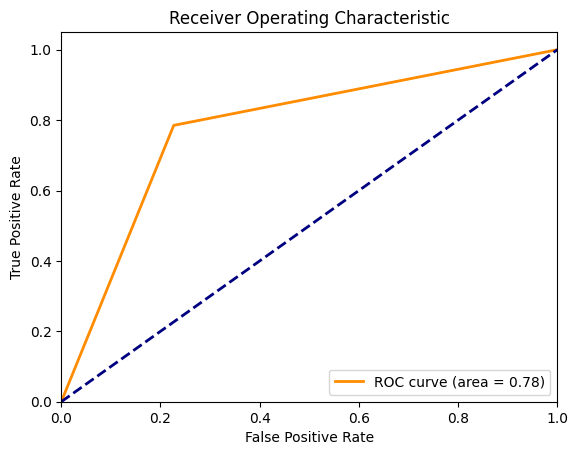

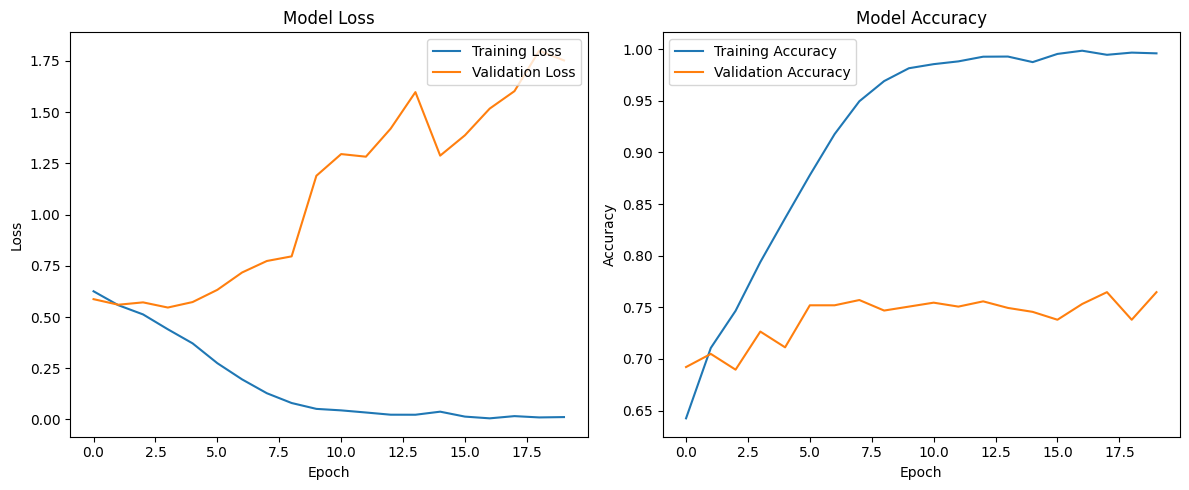

In [105]:
evaluate_models(proposed_model, test_model_1, test_model_2, X_train, y_train, X_val, y_val, X_test, y_test)

## 1.6 : comparing results

we run each implementation with the settings given in the question description

#### split ratio 0.3

In [109]:
X_train, X_test, y_train, y_test = train_test_split(aug_X, aug_y, test_size=0.3, stratify=aug_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# making labels on-hot
num_classes = 2
y_train = tf.one_hot(y_train, depth=num_classes)
y_val = tf.one_hot(y_val, depth=num_classes)
y_test = tf.one_hot(y_test, depth=num_classes)

In [111]:
proposed_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(64, activation='relu'),

    Dense(2, activation='softmax')
])


proposed_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

proposed_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_77 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_79 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                               

In [112]:
test_model_1 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(2, activation='softmax')
])

test_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_1.summary()


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_81 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_30 (Flatten)        (None, 8192)              0         
                                                                 
 dense_80 (Dense)            (None, 128)             

In [113]:
test_model_2 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

test_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_2.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_31 (Flatten)        (None, 32768)             0         
                                                                 
 dense_82 (Dense)            (None, 128)               4194432   
                                                                 
 dense_83 (Dense)            (None, 64)                8256      
                                                     

PROPOSED MODEL:
Epoch 1/20
163/163 [==============================] - 6s 10ms/step - loss: 0.6309 - accuracy: 0.6273 - val_loss: 0.6036 - val_accuracy: 0.6995
Epoch 2/20
163/163 [==============================] - 1s 8ms/step - loss: 0.5910 - accuracy: 0.6848 - val_loss: 0.5887 - val_accuracy: 0.6943
Epoch 3/20
163/163 [==============================] - 1s 8ms/step - loss: 0.5617 - accuracy: 0.7050 - val_loss: 0.5512 - val_accuracy: 0.7168
Epoch 4/20
163/163 [==============================] - 1s 8ms/step - loss: 0.5298 - accuracy: 0.7303 - val_loss: 0.5531 - val_accuracy: 0.7168
Epoch 5/20
163/163 [==============================] - 1s 8ms/step - loss: 0.4945 - accuracy: 0.7628 - val_loss: 0.4966 - val_accuracy: 0.7547
Epoch 6/20
163/163 [==============================] - 2s 10ms/step - loss: 0.4409 - accuracy: 0.7864 - val_loss: 0.4782 - val_accuracy: 0.7910
Epoch 7/20
163/163 [==============================] - 2s 12ms/step - loss: 0.3872 - accuracy: 0.8225 - val_loss: 0.4892 - val_accu

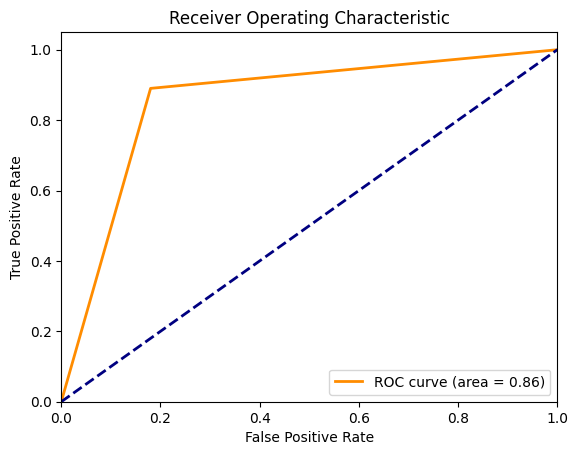

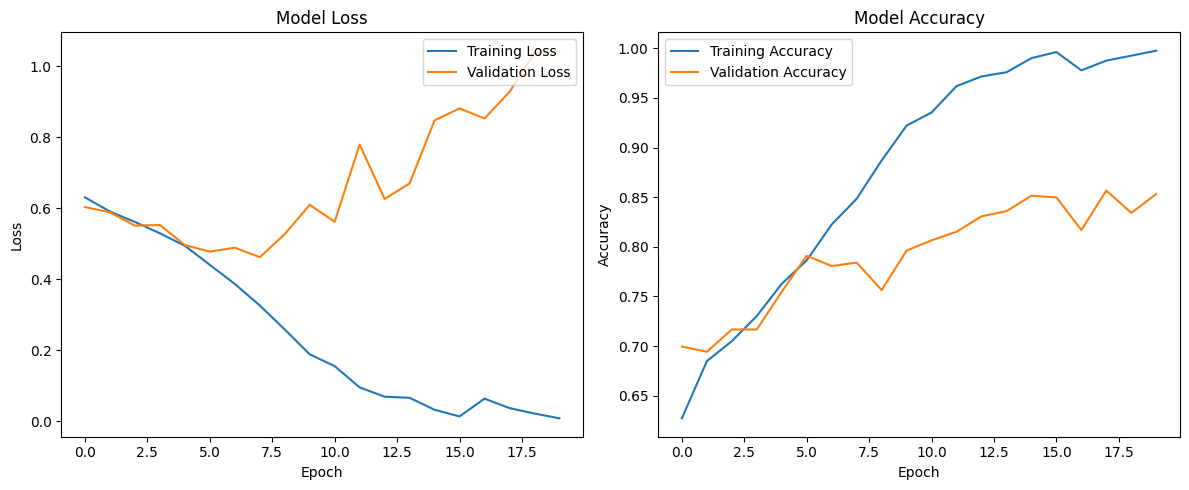





TESTING MODEL 1:
Epoch 1/20
163/163 [==============================] - 2s 7ms/step - loss: 0.6244 - accuracy: 0.6307 - val_loss: 0.6026 - val_accuracy: 0.6667
Epoch 2/20
163/163 [==============================] - 1s 5ms/step - loss: 0.5831 - accuracy: 0.6862 - val_loss: 0.5970 - val_accuracy: 0.6788
Epoch 3/20
163/163 [==============================] - 1s 7ms/step - loss: 0.5476 - accuracy: 0.7148 - val_loss: 0.5846 - val_accuracy: 0.6788
Epoch 4/20
163/163 [==============================] - 1s 7ms/step - loss: 0.5211 - accuracy: 0.7370 - val_loss: 0.5363 - val_accuracy: 0.7306
Epoch 5/20
163/163 [==============================] - 1s 7ms/step - loss: 0.4891 - accuracy: 0.7566 - val_loss: 0.5293 - val_accuracy: 0.7617
Epoch 6/20
163/163 [==============================] - 1s 7ms/step - loss: 0.4546 - accuracy: 0.7770 - val_loss: 0.5362 - val_accuracy: 0.7513
Epoch 7/20
163/163 [==============================] - 1s 5ms/step - loss: 0.4174 - accuracy: 0.8038 - val_loss: 0.5024 - val_ac

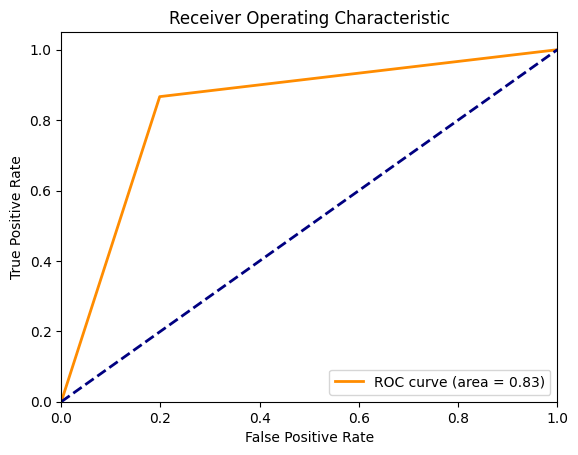

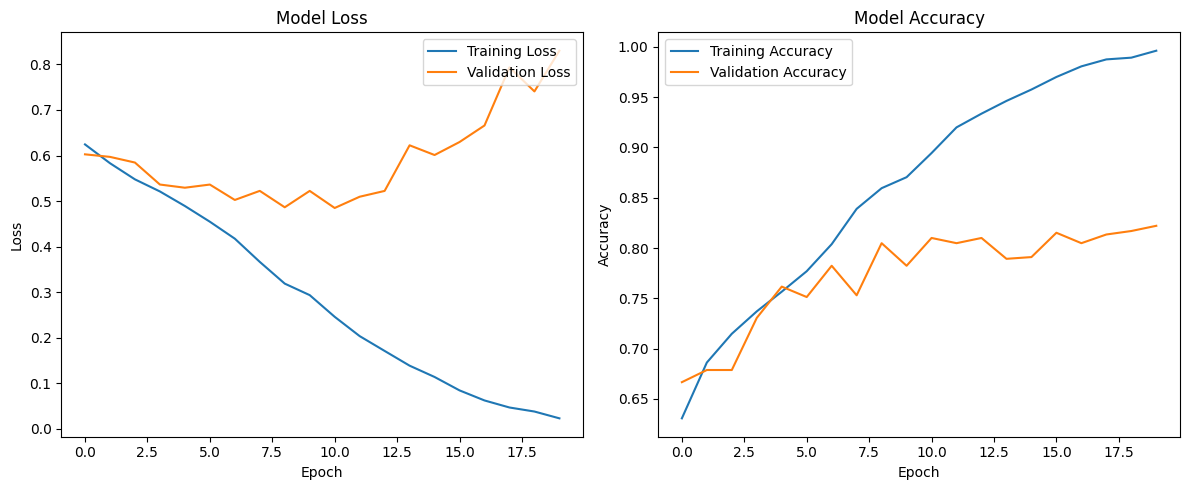





TESTING MODEL 2:
Epoch 1/20
163/163 [==============================] - 7s 17ms/step - loss: 0.6164 - accuracy: 0.6582 - val_loss: 0.6451 - val_accuracy: 0.6408
Epoch 2/20
163/163 [==============================] - 2s 10ms/step - loss: 0.5652 - accuracy: 0.7029 - val_loss: 0.5652 - val_accuracy: 0.7012
Epoch 3/20
163/163 [==============================] - 1s 9ms/step - loss: 0.5179 - accuracy: 0.7411 - val_loss: 0.5384 - val_accuracy: 0.7496
Epoch 4/20
163/163 [==============================] - 2s 10ms/step - loss: 0.4691 - accuracy: 0.7733 - val_loss: 0.5122 - val_accuracy: 0.7461
Epoch 5/20
163/163 [==============================] - 2s 10ms/step - loss: 0.3897 - accuracy: 0.8221 - val_loss: 0.5610 - val_accuracy: 0.7617
Epoch 6/20
163/163 [==============================] - 2s 9ms/step - loss: 0.2899 - accuracy: 0.8739 - val_loss: 0.5409 - val_accuracy: 0.7807
Epoch 7/20
163/163 [==============================] - 2s 10ms/step - loss: 0.1935 - accuracy: 0.9177 - val_loss: 0.6751 - v

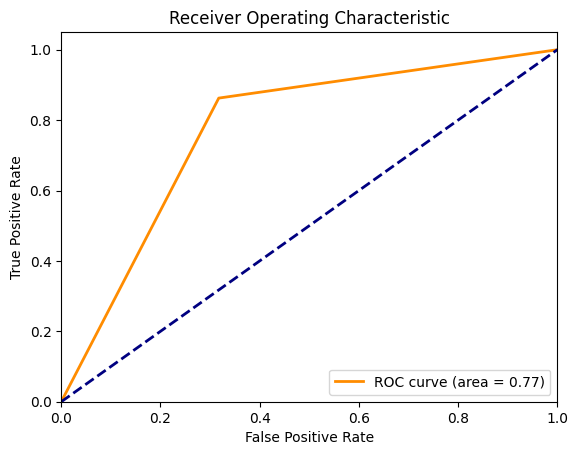

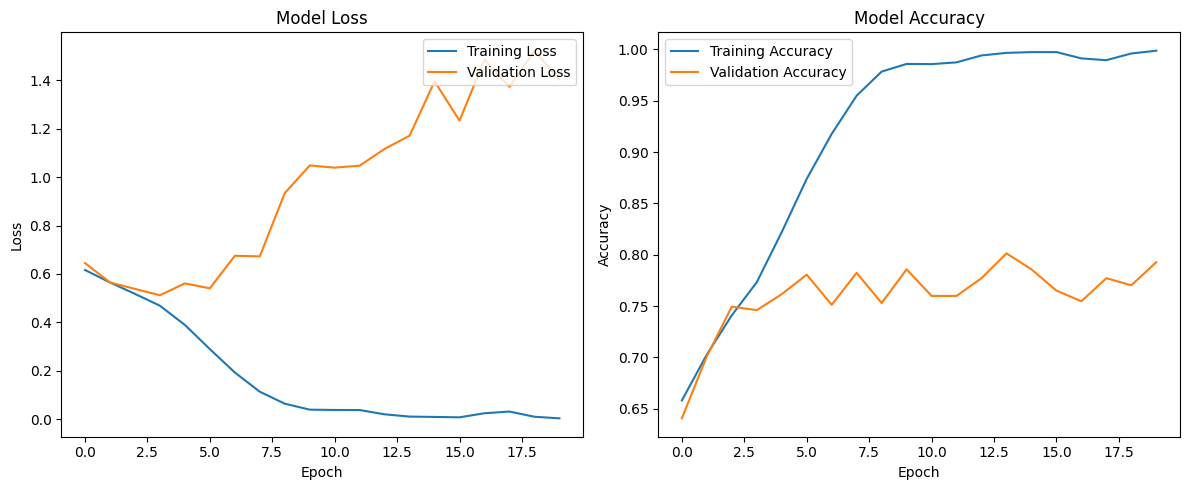

In [114]:
evaluate_models(proposed_model, test_model_1, test_model_2, X_train, y_train, X_val, y_val, X_test, y_test)

#### split ratio 0.5

In [116]:
X_train, X_test, y_train, y_test = train_test_split(aug_X, aug_y, test_size=0.5, stratify=aug_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# making labels on-hot
num_classes = 2
y_train = tf.one_hot(y_train, depth=num_classes)
y_val = tf.one_hot(y_val, depth=num_classes)
y_test = tf.one_hot(y_test, depth=num_classes)

In [117]:
proposed_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(64, activation='relu'),

    Dense(2, activation='softmax')
])


proposed_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

proposed_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_85 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_86 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_87 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                               

In [118]:
test_model_1 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(2, activation='softmax')
])

test_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_1.summary()


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_33 (Flatten)        (None, 8192)              0         
                                                                 
 dense_88 (Dense)            (None, 128)             

In [119]:
test_model_2 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

test_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_2.summary()


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_91 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_34 (Flatten)        (None, 32768)             0         
                                                                 
 dense_90 (Dense)            (None, 128)               4194432   
                                                                 
 dense_91 (Dense)            (None, 64)                8256      
                                                     

PROPOSED MODEL:
Epoch 1/20
117/117 [==============================] - 5s 14ms/step - loss: 0.6251 - accuracy: 0.6318 - val_loss: 0.6174 - val_accuracy: 0.6498
Epoch 2/20
117/117 [==============================] - 1s 10ms/step - loss: 0.5843 - accuracy: 0.6848 - val_loss: 0.5695 - val_accuracy: 0.7150
Epoch 3/20
117/117 [==============================] - 1s 10ms/step - loss: 0.5623 - accuracy: 0.7116 - val_loss: 0.5812 - val_accuracy: 0.6860
Epoch 4/20
117/117 [==============================] - 1s 9ms/step - loss: 0.5280 - accuracy: 0.7342 - val_loss: 0.5459 - val_accuracy: 0.7101
Epoch 5/20
117/117 [==============================] - 1s 9ms/step - loss: 0.4921 - accuracy: 0.7630 - val_loss: 0.5409 - val_accuracy: 0.7295
Epoch 6/20
117/117 [==============================] - 1s 9ms/step - loss: 0.4535 - accuracy: 0.7855 - val_loss: 0.5372 - val_accuracy: 0.7319
Epoch 7/20
117/117 [==============================] - 1s 8ms/step - loss: 0.4001 - accuracy: 0.8205 - val_loss: 0.5052 - val_accu

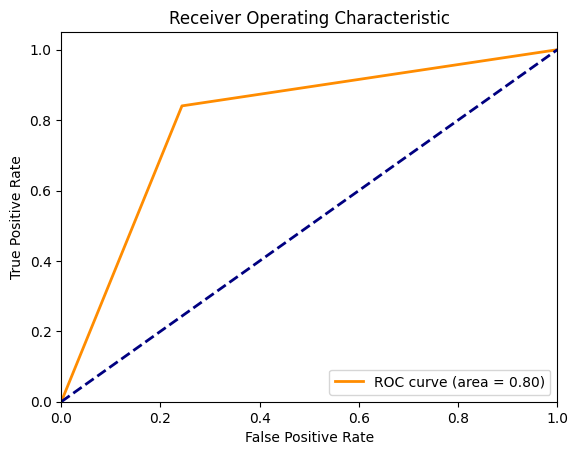

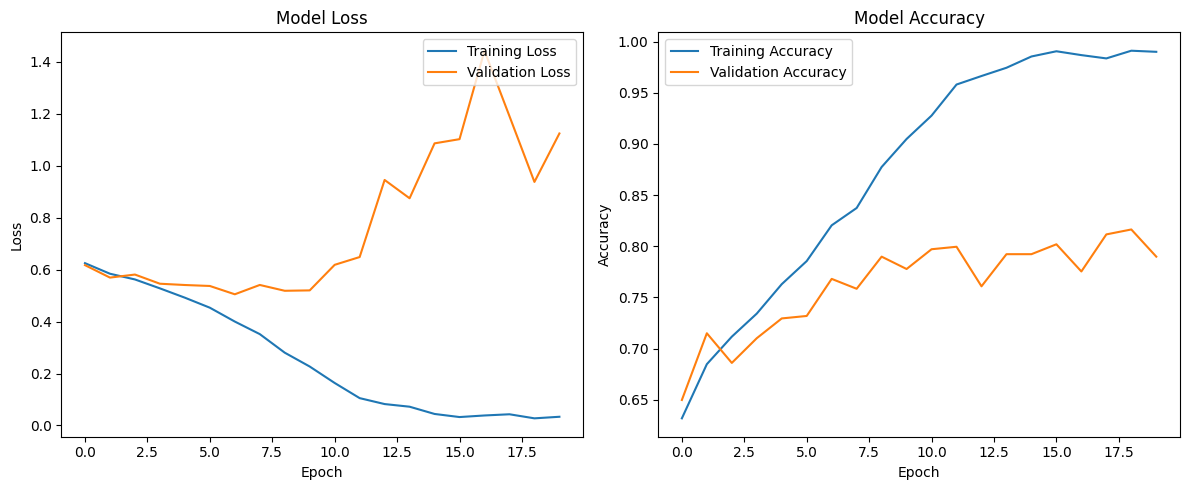





TESTING MODEL 1:
Epoch 1/20
117/117 [==============================] - 2s 7ms/step - loss: 0.6161 - accuracy: 0.6525 - val_loss: 0.6297 - val_accuracy: 0.6425
Epoch 2/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5698 - accuracy: 0.7020 - val_loss: 0.6157 - val_accuracy: 0.6691
Epoch 3/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5386 - accuracy: 0.7213 - val_loss: 0.5716 - val_accuracy: 0.6957
Epoch 4/20
117/117 [==============================] - 1s 5ms/step - loss: 0.5128 - accuracy: 0.7517 - val_loss: 0.5373 - val_accuracy: 0.7222
Epoch 5/20
117/117 [==============================] - 1s 6ms/step - loss: 0.4595 - accuracy: 0.7829 - val_loss: 0.5097 - val_accuracy: 0.7633
Epoch 6/20
117/117 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.8073 - val_loss: 0.5089 - val_accuracy: 0.7391
Epoch 7/20
117/117 [==============================] - 1s 5ms/step - loss: 0.3703 - accuracy: 0.8379 - val_loss: 0.6230 - val_ac

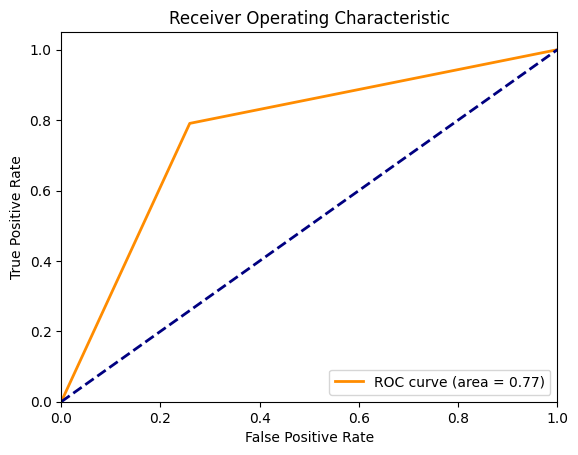

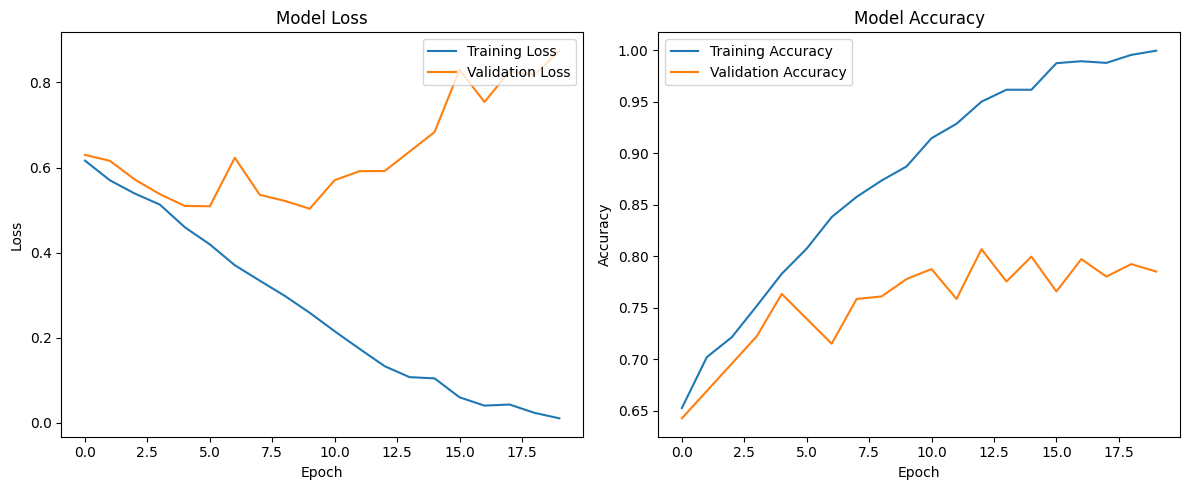





TESTING MODEL 2:
Epoch 1/20
117/117 [==============================] - 3s 11ms/step - loss: 0.6258 - accuracy: 0.6359 - val_loss: 0.6072 - val_accuracy: 0.6546
Epoch 2/20
117/117 [==============================] - 1s 8ms/step - loss: 0.5670 - accuracy: 0.7028 - val_loss: 0.5700 - val_accuracy: 0.7174
Epoch 3/20
117/117 [==============================] - 1s 8ms/step - loss: 0.5266 - accuracy: 0.7372 - val_loss: 0.5764 - val_accuracy: 0.7077
Epoch 4/20
117/117 [==============================] - 1s 8ms/step - loss: 0.4619 - accuracy: 0.7751 - val_loss: 0.5380 - val_accuracy: 0.7440
Epoch 5/20
117/117 [==============================] - 1s 9ms/step - loss: 0.3856 - accuracy: 0.8221 - val_loss: 0.5166 - val_accuracy: 0.7536
Epoch 6/20
117/117 [==============================] - 1s 10ms/step - loss: 0.3033 - accuracy: 0.8729 - val_loss: 0.5232 - val_accuracy: 0.7633
Epoch 7/20
117/117 [==============================] - 1s 9ms/step - loss: 0.2080 - accuracy: 0.9191 - val_loss: 0.6804 - val_

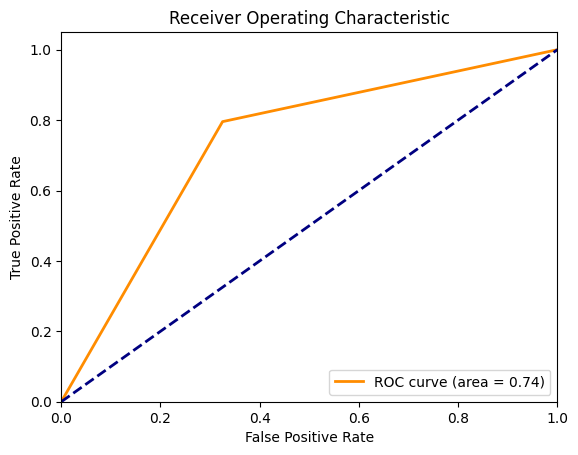

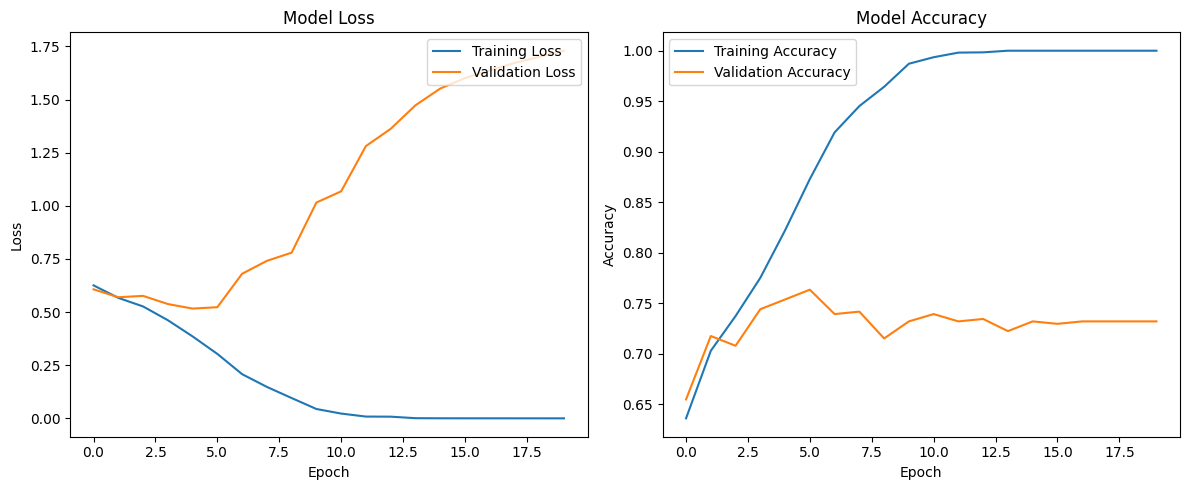

In [120]:
evaluate_models(proposed_model, test_model_1, test_model_2, X_train, y_train, X_val, y_val, X_test, y_test)

#### drop out effect

In [121]:
X_train, X_test, y_train, y_test = train_test_split(aug_X, aug_y, test_size=0.05, stratify=aug_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# making labels on-hot
num_classes = 2
y_train = tf.one_hot(y_train, depth=num_classes)
y_val = tf.one_hot(y_val, depth=num_classes)
y_test = tf.one_hot(y_test, depth=num_classes)

In [128]:
proposed_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.2),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(64, activation='relu'),

    Dense(2, activation='softmax')
])


proposed_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

proposed_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 conv2d_109 (Conv2D)         (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_110 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 conv2d_111 (Conv2D)         (None, 32, 32, 32)        9248      
                                                     

In [127]:
test_model_1 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),

    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.2),

    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(2, activation='softmax')
])

test_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_1.summary()


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_107 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)      

In [126]:
test_model_2 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

test_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_2.summary()


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 conv2d_105 (Conv2D)         (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 flatten_39 (Flatten)        (None, 32768)             0         
                                                                 
 dense_104 (Dense)           (None, 128)               4194432   
                                                     

PROPOSED MODEL:
Epoch 1/20
221/221 [==============================] - 8s 20ms/step - loss: 0.6278 - accuracy: 0.6272 - val_loss: 0.6364 - val_accuracy: 0.6692
Epoch 2/20
221/221 [==============================] - 3s 14ms/step - loss: 0.5905 - accuracy: 0.6827 - val_loss: 0.5845 - val_accuracy: 0.7023
Epoch 3/20
221/221 [==============================] - 3s 13ms/step - loss: 0.5610 - accuracy: 0.7037 - val_loss: 0.5456 - val_accuracy: 0.7417
Epoch 4/20
221/221 [==============================] - 3s 13ms/step - loss: 0.5394 - accuracy: 0.7267 - val_loss: 0.5224 - val_accuracy: 0.7481
Epoch 5/20
221/221 [==============================] - 4s 19ms/step - loss: 0.5150 - accuracy: 0.7426 - val_loss: 0.4963 - val_accuracy: 0.7926
Epoch 6/20
221/221 [==============================] - 3s 15ms/step - loss: 0.4807 - accuracy: 0.7694 - val_loss: 0.4686 - val_accuracy: 0.7748
Epoch 7/20
221/221 [==============================] - 3s 12ms/step - loss: 0.4414 - accuracy: 0.7876 - val_loss: 0.4301 - val_

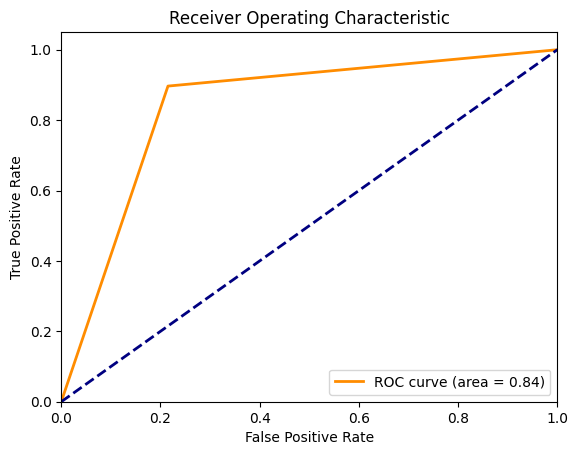

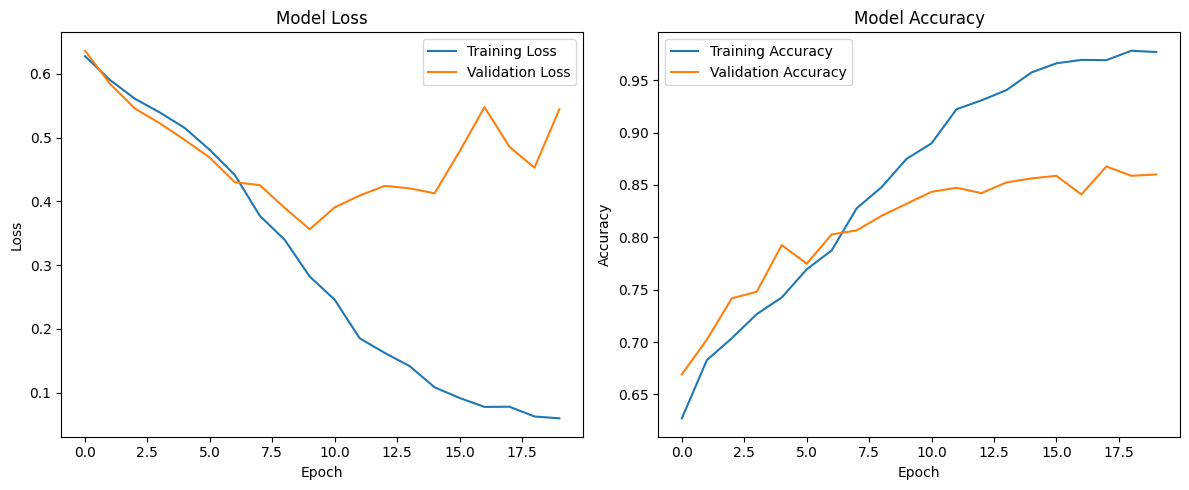





TESTING MODEL 1:
Epoch 1/20
221/221 [==============================] - 3s 7ms/step - loss: 0.6146 - accuracy: 0.6496 - val_loss: 0.5849 - val_accuracy: 0.7010
Epoch 2/20
221/221 [==============================] - 1s 6ms/step - loss: 0.5743 - accuracy: 0.6928 - val_loss: 0.5778 - val_accuracy: 0.7087
Epoch 3/20
221/221 [==============================] - 1s 6ms/step - loss: 0.5574 - accuracy: 0.7132 - val_loss: 0.5336 - val_accuracy: 0.7405
Epoch 4/20
221/221 [==============================] - 2s 8ms/step - loss: 0.5301 - accuracy: 0.7303 - val_loss: 0.5081 - val_accuracy: 0.7532
Epoch 5/20
221/221 [==============================] - 1s 6ms/step - loss: 0.4914 - accuracy: 0.7615 - val_loss: 0.5085 - val_accuracy: 0.7392
Epoch 6/20
221/221 [==============================] - 1s 6ms/step - loss: 0.4594 - accuracy: 0.7789 - val_loss: 0.4714 - val_accuracy: 0.7659
Epoch 7/20
221/221 [==============================] - 2s 7ms/step - loss: 0.4212 - accuracy: 0.8011 - val_loss: 0.4472 - val_ac

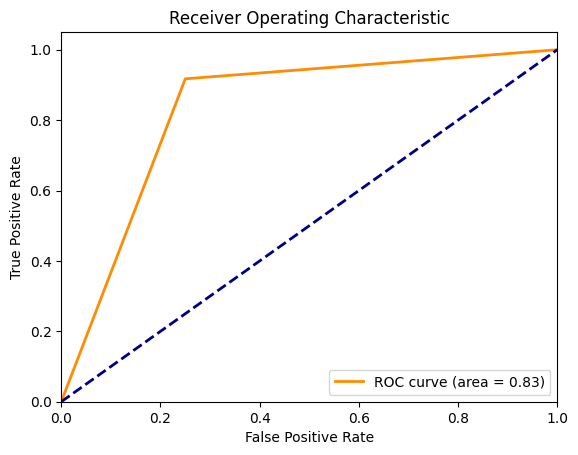

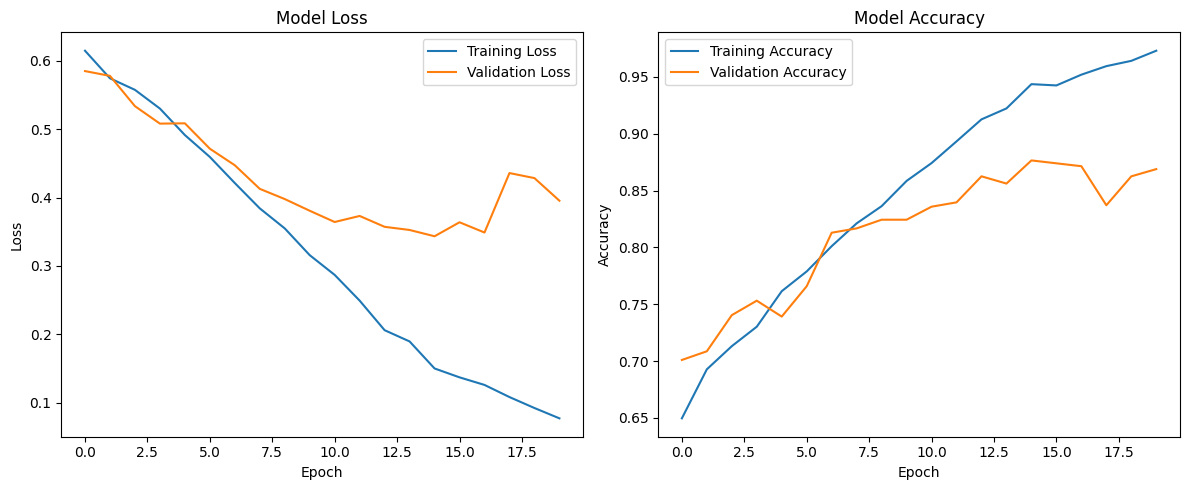





TESTING MODEL 2:
Epoch 1/20
221/221 [==============================] - 4s 12ms/step - loss: 0.6182 - accuracy: 0.6421 - val_loss: 0.5932 - val_accuracy: 0.6845
Epoch 2/20
221/221 [==============================] - 2s 11ms/step - loss: 0.5544 - accuracy: 0.7099 - val_loss: 0.5265 - val_accuracy: 0.7468
Epoch 3/20
221/221 [==============================] - 2s 10ms/step - loss: 0.4943 - accuracy: 0.7515 - val_loss: 0.4947 - val_accuracy: 0.7468
Epoch 4/20
221/221 [==============================] - 2s 10ms/step - loss: 0.4283 - accuracy: 0.7943 - val_loss: 0.4393 - val_accuracy: 0.7964
Epoch 5/20
221/221 [==============================] - 2s 10ms/step - loss: 0.3404 - accuracy: 0.8433 - val_loss: 0.4246 - val_accuracy: 0.8117
Epoch 6/20
221/221 [==============================] - 2s 10ms/step - loss: 0.2604 - accuracy: 0.8870 - val_loss: 0.4746 - val_accuracy: 0.8028
Epoch 7/20
221/221 [==============================] - 3s 11ms/step - loss: 0.1836 - accuracy: 0.9232 - val_loss: 0.5892 -

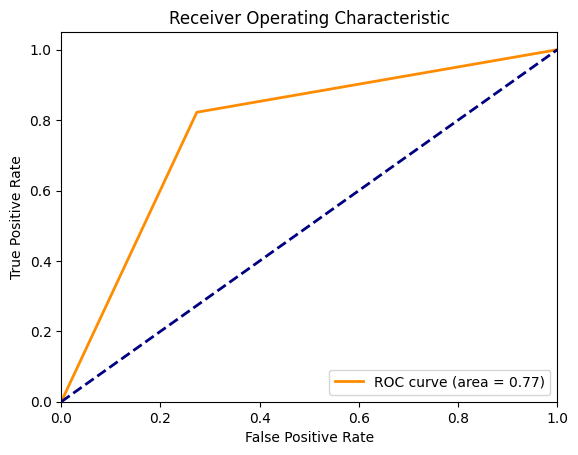

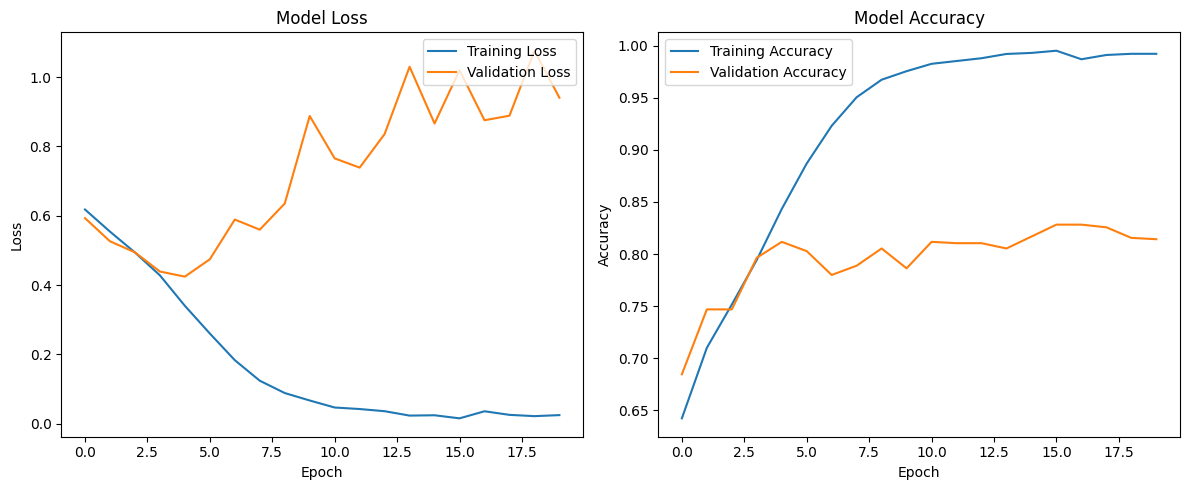

In [129]:
evaluate_models(proposed_model, test_model_1, test_model_2, X_train, y_train, X_val, y_val, X_test, y_test)

#### Glorot Initializer effect

In [130]:
X_train, X_test, y_train, y_test = train_test_split(aug_X, aug_y, test_size=0.05, stratify=aug_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# making labels on-hot
num_classes = 2
y_train = tf.one_hot(y_train, depth=num_classes)
y_val = tf.one_hot(y_val, depth=num_classes)
y_test = tf.one_hot(y_test, depth=num_classes)

In [131]:
proposed_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1), kernel_initializer=GlorotUniform()),

    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()),

    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),

    Dense(64, activation='relu'),

    Dense(2, activation='softmax')
])


proposed_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

proposed_model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 conv2d_113 (Conv2D)         (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_114 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 conv2d_115 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                               

In [133]:
test_model_1 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1), kernel_initializer=GlorotUniform()),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu', kernel_initializer=GlorotUniform()),

    Dense(2, activation='softmax', kernel_initializer=GlorotUniform())
])

test_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_1.summary()


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_119 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_44 (Flatten)        (None, 8192)              0         
                                                                 
 dense_117 (Dense)           (None, 128)             

In [134]:
test_model_2 = Sequential([

    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1), kernel_initializer=GlorotUniform()),
    Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=GlorotUniform()),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu', kernel_initializer=GlorotUniform()),
    Dense(64, activation='relu', kernel_initializer=GlorotUniform()),
    Dense(2, activation='softmax', kernel_initializer=GlorotUniform())
])

test_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_model_2.summary()


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 64, 64, 32)        320       
                                                                 
 conv2d_121 (Conv2D)         (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_45 (Flatten)        (None, 32768)             0         
                                                                 
 dense_119 (Dense)           (None, 128)               4194432   
                                                                 
 dense_120 (Dense)           (None, 64)                8256      
                                                     

PROPOSED MODEL:
Epoch 1/20
221/221 [==============================] - 6s 12ms/step - loss: 0.6629 - accuracy: 0.6007 - val_loss: 0.6314 - val_accuracy: 0.6310
Epoch 2/20
221/221 [==============================] - 2s 10ms/step - loss: 0.5959 - accuracy: 0.6730 - val_loss: 0.5750 - val_accuracy: 0.7176
Epoch 3/20
221/221 [==============================] - 2s 9ms/step - loss: 0.5564 - accuracy: 0.7106 - val_loss: 0.5628 - val_accuracy: 0.7226
Epoch 4/20
221/221 [==============================] - 2s 9ms/step - loss: 0.5229 - accuracy: 0.7355 - val_loss: 0.5257 - val_accuracy: 0.7443
Epoch 5/20
221/221 [==============================] - 2s 9ms/step - loss: 0.4751 - accuracy: 0.7697 - val_loss: 0.5344 - val_accuracy: 0.7494
Epoch 6/20
221/221 [==============================] - 2s 9ms/step - loss: 0.4170 - accuracy: 0.8010 - val_loss: 0.4900 - val_accuracy: 0.7659
Epoch 7/20
221/221 [==============================] - 2s 10ms/step - loss: 0.3580 - accuracy: 0.8320 - val_loss: 0.4996 - val_accu

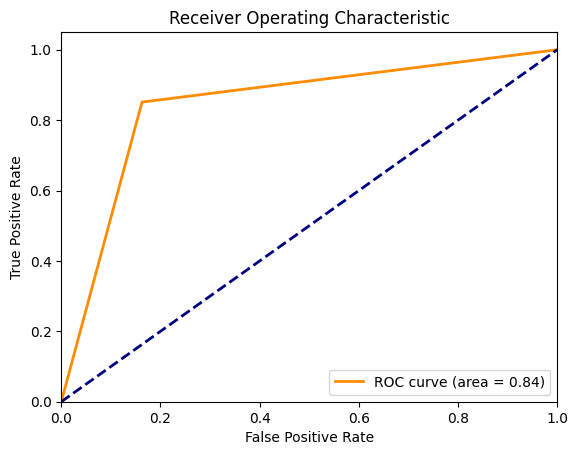

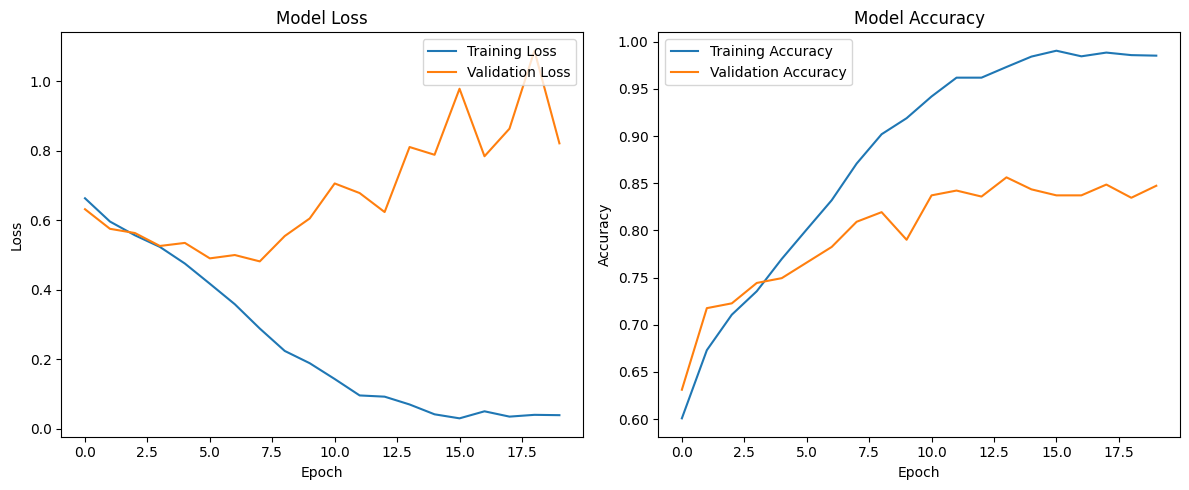





TESTING MODEL 1:
Epoch 1/20
221/221 [==============================] - 3s 6ms/step - loss: 0.6099 - accuracy: 0.6644 - val_loss: 0.5805 - val_accuracy: 0.7074
Epoch 2/20
221/221 [==============================] - 1s 5ms/step - loss: 0.5565 - accuracy: 0.7149 - val_loss: 0.5545 - val_accuracy: 0.7226
Epoch 3/20
221/221 [==============================] - 1s 5ms/step - loss: 0.5189 - accuracy: 0.7437 - val_loss: 0.5378 - val_accuracy: 0.7519
Epoch 4/20
221/221 [==============================] - 1s 7ms/step - loss: 0.4830 - accuracy: 0.7652 - val_loss: 0.5154 - val_accuracy: 0.7430
Epoch 5/20
221/221 [==============================] - 2s 7ms/step - loss: 0.4342 - accuracy: 0.8007 - val_loss: 0.5000 - val_accuracy: 0.7430
Epoch 6/20
221/221 [==============================] - 1s 6ms/step - loss: 0.3955 - accuracy: 0.8225 - val_loss: 0.4735 - val_accuracy: 0.7863
Epoch 7/20
221/221 [==============================] - 1s 5ms/step - loss: 0.3428 - accuracy: 0.8457 - val_loss: 0.4606 - val_ac

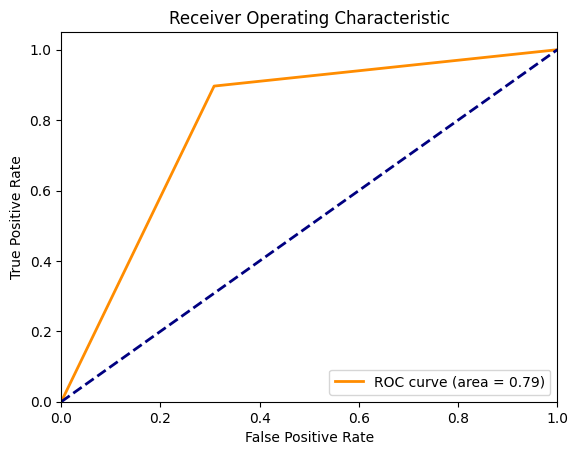

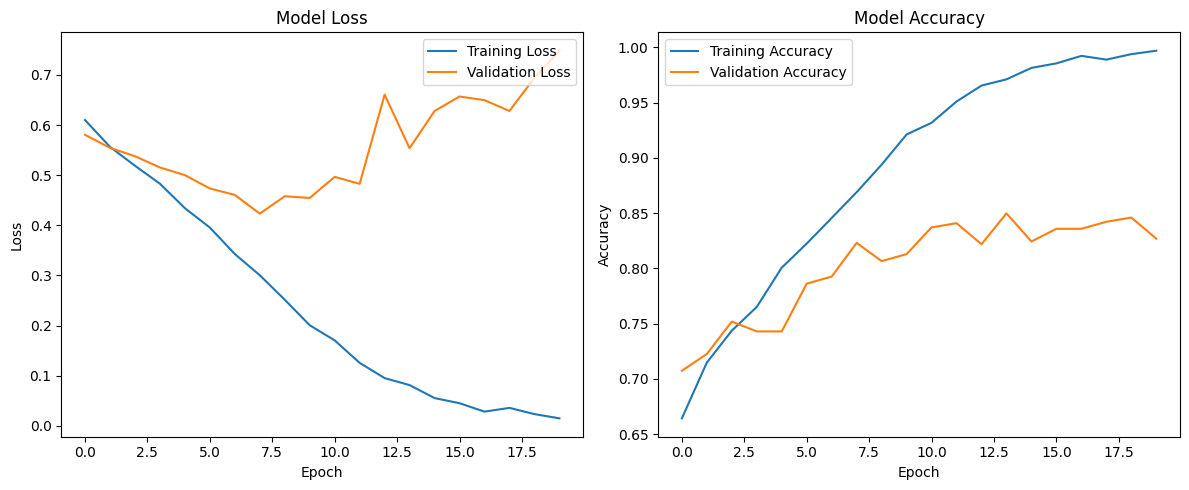





TESTING MODEL 2:
Epoch 1/20
221/221 [==============================] - 3s 9ms/step - loss: 0.6104 - accuracy: 0.6499 - val_loss: 0.6297 - val_accuracy: 0.6145
Epoch 2/20
221/221 [==============================] - 2s 9ms/step - loss: 0.5597 - accuracy: 0.7082 - val_loss: 0.5443 - val_accuracy: 0.7316
Epoch 3/20
221/221 [==============================] - 2s 10ms/step - loss: 0.4922 - accuracy: 0.7594 - val_loss: 0.5242 - val_accuracy: 0.7379
Epoch 4/20
221/221 [==============================] - 2s 8ms/step - loss: 0.4194 - accuracy: 0.8040 - val_loss: 0.5200 - val_accuracy: 0.7570
Epoch 5/20
221/221 [==============================] - 2s 9ms/step - loss: 0.3366 - accuracy: 0.8494 - val_loss: 0.4891 - val_accuracy: 0.7697
Epoch 6/20
221/221 [==============================] - 2s 8ms/step - loss: 0.2394 - accuracy: 0.8946 - val_loss: 0.4945 - val_accuracy: 0.7850
Epoch 7/20
221/221 [==============================] - 2s 8ms/step - loss: 0.1476 - accuracy: 0.9416 - val_loss: 0.6283 - val_a

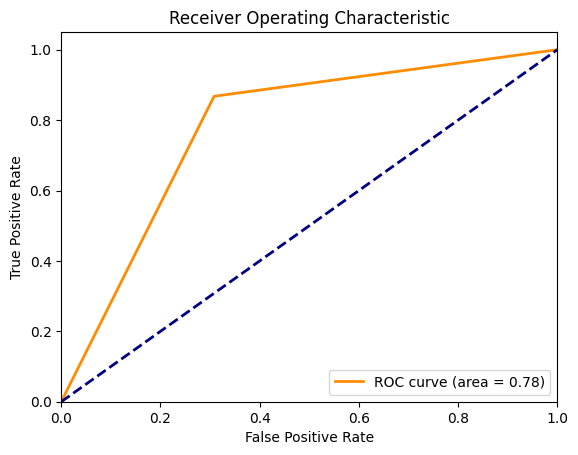

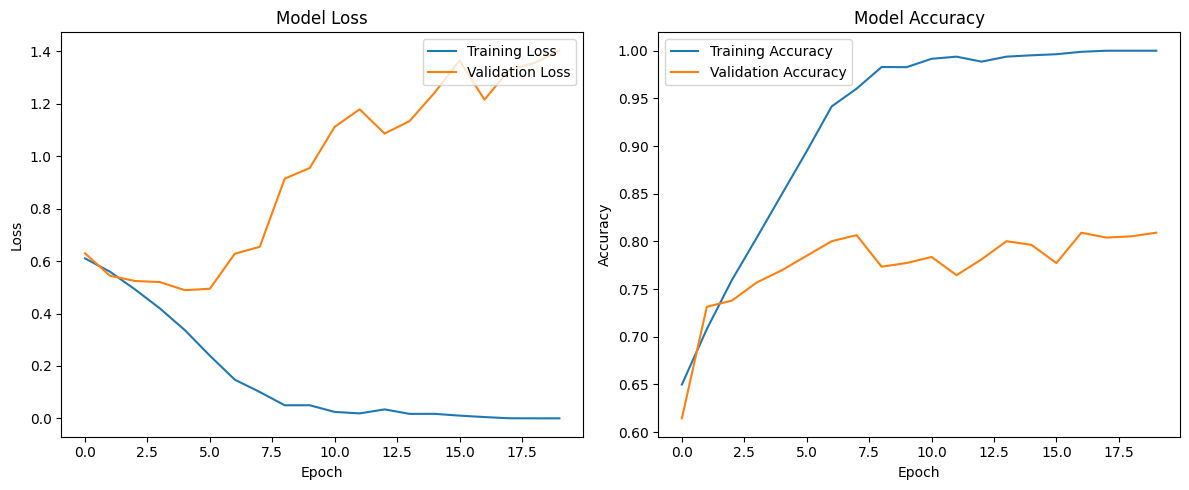

In [135]:
evaluate_models(proposed_model, test_model_1, test_model_2, X_train, y_train, X_val, y_val, X_test, y_test)